In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [6]:
df = pd.read_csv("../data/dataset.csv")

In [ ]:
# Create DateTime column
df['DateTime'] = pd.to_datetime(
    df['LastUpdatedDate'] + " " + df['LastUpdatedTime'],
    format="%d-%m-%Y %H:%M:%S"
)

In [8]:
# Encode categorical traffic levels
traffic_map = {"low": 1, "average": 2, "high": 3}
vehicle_map = {"car": 1.0, "bike": 0.5, "truck": 1.5, "cycle": 0.3}

In [9]:
df['TrafficNum'] = df['TrafficConditionNearby'].map(traffic_map)
df['VehicleWeight'] = df['VehicleType'].map(vehicle_map)
df['OccRate'] = df['Occupancy'] / df['Capacity']

In [13]:
def model2_pricing(lot_data, base_price=10):
    lot = lot_data.copy()
    
    # Coefficients (tunable)
    alpha, beta, gamma, delta, epsilon = 1.0, 0.5, 0.4, 1.0, 0.7
    
    # Demand function
    lot['Demand'] = (alpha * lot['OccRate'] +
                     beta * lot['QueueLength'] -
                     gamma * lot['TrafficNum'] +
                     delta * lot['IsSpecialDay'] +
                     epsilon * lot['VehicleWeight'])
    
    # Normalize demand
    scaler = MinMaxScaler()
    lot['NormDemand'] = scaler.fit_transform(lot[['Demand']])
    
    # Price calculation
    lam = 0.8
    lot['Model2Price'] = base_price * (1 + lam * lot['NormDemand'])
    
    # Cap prices between 5 and 20
    lot['Model2Price'] = lot['Model2Price'].clip(lower=5, upper=20)
    
    return lot

In [14]:
lot_id = "BHMBCCMKT01"
lot_data = df[df['SystemCodeNumber'] == lot_id].sort_values('DateTime')

lot_m2 = model2_pricing(lot_data)

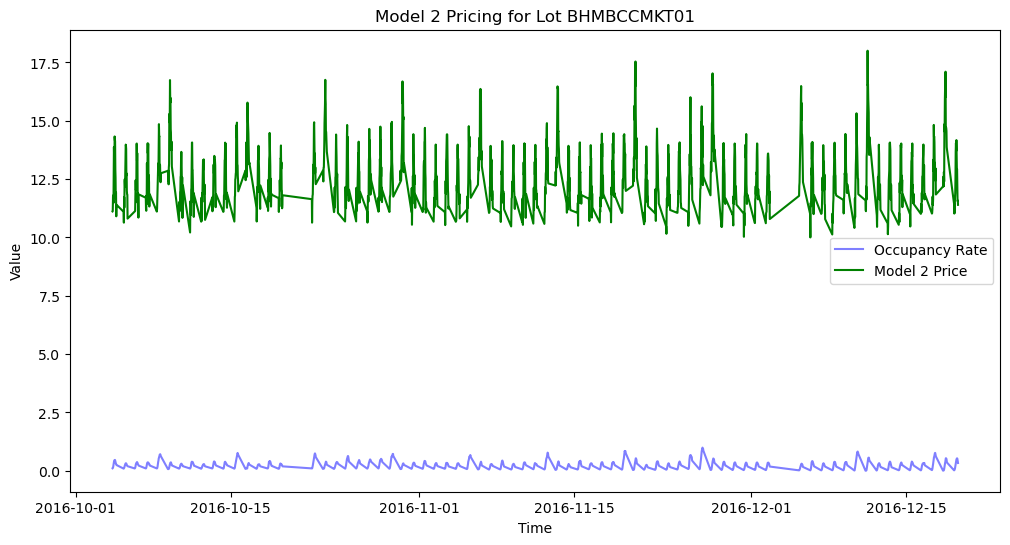

In [15]:
plt.figure(figsize=(12,6))
plt.plot(lot_m2['DateTime'], lot_m2['OccRate'], label="Occupancy Rate", alpha=0.5, color="blue")
plt.plot(lot_m2['DateTime'], lot_m2['Model2Price'], label="Model 2 Price", color="green")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Model 2 Pricing for Lot {lot_id}")
plt.legend()
plt.show()